# TUTORIAL DE CARGA Y PROCESAMIENTO DE DATOS

Autor : Sasank Chilamkurthy

Se requiere mucho esfuerzo para resolver cualquier problema de aprendizaje automático para preparar los datos. PyTorch proporciona muchas herramientas para facilitar la carga de datos y, con suerte, hacer que su código sea más legible. En este tutorial, veremos cómo cargar y preprocesar / aumentar datos de un conjunto de datos no trivial.

Para ejecutar este tutorial, asegúrese de que estén instalados los siguientes paquetes:

scikit-image: Para imagen io y transformaciones

pandas: Para un análisis de CSV más fácil

In [10]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

print(torch.cuda.is_available())

#print(torch.__version__)

torch.__version__

True


'1.2.0'

El conjunto de datos que vamos a tratar es el de la pose facial. Esto significa que una cara se anota así:

image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
0805personali01.jpg,27,83,27,98, ... 84,134
1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312

In [11]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


Vamos a escribir una función auxiliar simple para mostrar una imagen y sus puntos de referencia y usarla para mostrar una muestra.

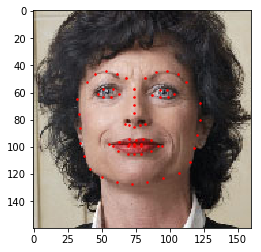

In [12]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

# Clase de conjunto de datos

torch.utils.data.Datasetes una clase abstracta que representa un conjunto de datos. Su conjunto de datos personalizado debe heredar Datasety anular los siguientes métodos:

__len__para que len(dataset)devuelva el tamaño del conjunto de datos.

__getitem__para soportar la indexación de tal manera que dataset[i]se pueda usar para obtenerith muestra

Creemos una clase de conjunto de datos para nuestro conjunto de datos de puntos de referencia. Leeremos el csv __init__ pero dejaremos la lectura de imágenes __getitem__. Esto es eficiente en memoria porque todas las imágenes no se almacenan en la memoria a la vez, sino que se leen según sea necesario.

La muestra de nuestro conjunto de datos será un dict . Nuestro conjunto de datos tomará un argumento opcional para que cualquier procesamiento requerido pueda aplicarse en la muestra. Veremos la utilidad de en la siguiente sección.{'image': image, 'landmarks': landmarks}transformtransform

In [13]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

Creemos una instancia de esta clase e iteremos a través de las muestras de datos. Imprimiremos los tamaños de las primeras 4 muestras y mostraremos sus puntos de referencia.

0 (324, 215, 3) (68, 2)


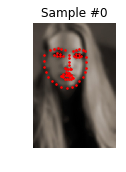

1 (500, 333, 3) (68, 2)


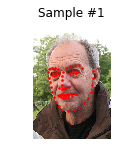

2 (250, 258, 3) (68, 2)


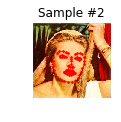

3 (434, 290, 3) (68, 2)


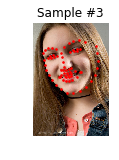

In [14]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

# Transforma

Un problema que podemos ver de lo anterior es que las muestras no son del mismo tamaño. La mayoría de las redes neuronales esperan imágenes de un tamaño fijo. Por lo tanto, necesitaremos escribir un código de preprocesamiento. Creemos tres transformaciones:

Rescale: para escalar la imagen

RandomCrop: para recortar de la imagen al azar. Este es el aumento de datos.

ToTensor: para convertir las imágenes numpy en imágenes de antorcha (necesitamos intercambiar ejes).

Los escribiremos como clases invocables en lugar de funciones simples para que los parámetros de la transformación no tengan que pasarse cada vez que se llama. Para esto, solo necesitamos implementar el método __call__ y, si es necesario, el método __init__. Entonces podemos usar una transformación como esta:

tsfm = Transform(params)
transformed_sample = tsfm(sample)

In [15]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

# Componer transformaciones

Ahora, aplicamos las transformadas en una muestra.

Digamos que queremos reescalar el lado más corto de la imagen a 256 y luego recortar aleatoriamente un cuadrado de tamaño 224. es decir, queremos componer Rescaley RandomCroptransformar. torchvision.transforms.Composees una clase invocable simple que nos permite hacer esto.

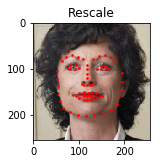

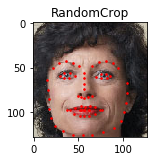

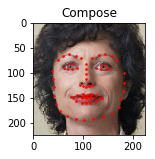

In [16]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

# Iterando a través del conjunto de datos

Pongamos todo esto junto para crear un conjunto de datos con transformaciones compuestas. Para resumir, cada vez que se muestrea este conjunto de datos:

Se lee una imagen del archivo sobre la marcha
Las transformaciones se aplican en la imagen leída
Como una de las transformaciones es aleatoria, los datos se aumentan en el muestreo
Podemos iterar sobre el conjunto de datos creado con un bucle como antes.for i in range

In [17]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


Sin embargo, estamos perdiendo muchas características al usar un bucle for simple para iterar sobre los datos. En particular, nos estamos perdiendo:

Lote de datos
Barajar los datos
Cargue los datos en paralelo utilizando multiprocessingtrabajadores.

torch.utils.data.DataLoaderes un iterador que proporciona todas estas características. Los parámetros utilizados a continuación deben ser claros. Un parámetro de interés es collate_fn. Puede especificar cómo se deben agrupar exactamente las muestras collate_fn. Sin embargo, la clasificación predeterminada debería funcionar bien para la mayoría de los casos de uso.

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


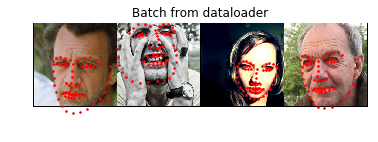

In [22]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=0)
    
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break